In [1]:
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction
from matipo.util.etl import deinterlace
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    if (p*4)%l==0: # only print 4 times per run
        print(p, '/', l)

def calc_b_value(par):
    G = 0.18*np.linalg.norm(par.g_diff) # T/m
    gamma = 267.522e6 # rad/s/T
    d = par.t_diff
    D = par.t_diff # roughly
    b = gamma*gamma*G*G*d*d*(D-d/3) # s/m^2
    b *= 1e-6 # s/mm^2
    return b

def kspace_data(seq):
    return decimate(
        deinterlace(
            seq.data,
            seq.par.n_ETL,
            1,
            seq.par.n_phase_2,
            seq.par.n_samples
        ), DECIMATION, axis=1)

def signal_mask(image, ratio):
    mask = np.copy(image)
    thresh = ratio*np.max(mask) # adjust to alter the threshold, quarter of maximum is a good starting point
    mask[mask > thresh] = 1
    mask[mask <= thresh] = 0
    return mask

GAMMA = 1/1.5
def plot_ADC(im_base, im_diff, b_base, b_diff, mask_ratio=0.2):
    # calculate apparent diffusion coefficient and mask out regions with no signal
    ADC = (-np.log(im_diff/im_base) / b_diff) * signal_mask(im_base, mask_ratio)

    # use same vmax for the two plots so they are comparable
    vmax = np.max(im_base)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100)
    axes[0].imshow(im_base**GAMMA, cmap='gray', vmin=0, vmax=vmax**GAMMA)
    axes[0].set_title(f'W/O Diffusion Weighting (b = {b_base:.0f} S/mm$^2$)')
    axes[0].axis('off')
    axes[1].imshow(im_diff**GAMMA, cmap='gray', vmin=0, vmax=vmax**GAMMA)
    axes[1].set_title(f'With Diffusion Weighting (b = {b_diff:.0f} S/mm$^2$)')
    axes[1].axis('off')
    im3 = axes[2].imshow(1e3*ADC, cmap='gray')
    axes[2].set_title('Apparent Diffusion Coefficient')
    axes[2].axis('off')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im3, cax=cax, orientation='vertical')
    cbar.set_label('$10^{-3}$ mm$^2$/S')
    plt.show()

In [2]:
# set save directory and base file name
SAVE_DIR = '/home/data/DWI-2D'
SAVE_NAME = 'test'

# make the save directory if it doesn't exist
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

### Diffusion Weighted Imaging using Pulsed Gradient Spin Echo module with RARE readout

Pulse sequence `PGSE_RARE.py`:

`90 pulse | delay | diffusion gradient | 180 pulse | diffusion gradient | delay | read prephase gradient | [ 180 pulse | +ve phase gradient | read gradient + acquisition | -ve phase gradient ]`

Notes:
 - `[]` repeats for `n_ETL`, stepping through phase gradients.
 - The Diffusion gradient has amplitude `g_diff` and flat time `t_diff`.
 - The echo time of the first echo is different from the RARE readout echos.
 - The delays before and after the diffusion module are automatically calculated to align the echos.

In [27]:
# load sequence from local directory
seq = Sequence('PGSE_RARE.py')

seq.loadpar(GLOBALS_DIR+'shims.yaml')
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')

# seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'softpulse_90_8.0mm.yaml')
# slice through Z axis using magnitude from softpulse calibration file
g_slice = seq.par.g_slice*np.array([0, 0, 1.0])

DECIMATION = 4

g_diff = (0, 0.4, 0)

seq.setpar(
    # use maximum slice gradient for correct thickness or reduce for thicker, (0,0,0) for projection
    g_slice=g_slice,
    
    n_ETL=64, # Echo Train Length, number of echos in each CPMG train, reduce if sample has short T2
    
    # for 2D, just use phase_2 and set n_phase_1 to 1 with no gradient
    n_phase_1=1,
    g_phase_1=(0,0,0),
    
    t_diff=12e-3, # diffusion gradient ON time
    
    # 32 phase steps
    n_phase_2=64, # changes resolution
    g_phase_2=(0,-0.8,0),
    
    # frequency encode with oversampling for flat filtering
    t_dw=10e-6, # changes FOV
    n_samples=64*DECIMATION,  # changes resolution
    g_read=(0.3,0,0), # changes FOV
    
    t_end=0.5
)

# set calculated read gradient pulse duration
seq.setpar(t_read=seq.par.t_dw*seq.par.n_samples)
# set phase  pulse duration so that the area is half the read pulse area
seq.setpar(t_phase=np.abs(np.linalg.norm(seq.par.g_read)/np.linalg.norm(seq.par.g_phase_2))*seq.par.t_read/2)

seq.setpar(n_scans=4, g_diff=(0,0,0)) # set no diffusion gradient for reference
b_base = calc_b_value(seq.par)
print(f'Acquiring image with zero diffusion gradient (b = {b_base:.0f} S/mm^2)')
await seq.run(print_progress)
y_base = kspace_data(seq) # arrange raw data into 2D kspace array

seq.setpar(n_scans=16, g_diff=g_diff) # set positive diffusion gradient
b_diff = calc_b_value(seq.par)
print(f'Acquiring image with positive diffusion gradient (b = {b_diff:.0f} S/mm^2)')
await seq.run(print_progress)
y_diff = kspace_data(seq) # arrange raw data into 2D kspace array

Acquiring image with zero diffusion gradient (b = 0 S/mm^2)
1 / 4
2 / 4
3 / 4
4 / 4
Acquiring image with positive diffusion gradient (b = 427 S/mm^2)
4 / 16
8 / 16
12 / 16
16 / 16


### K-Space plots

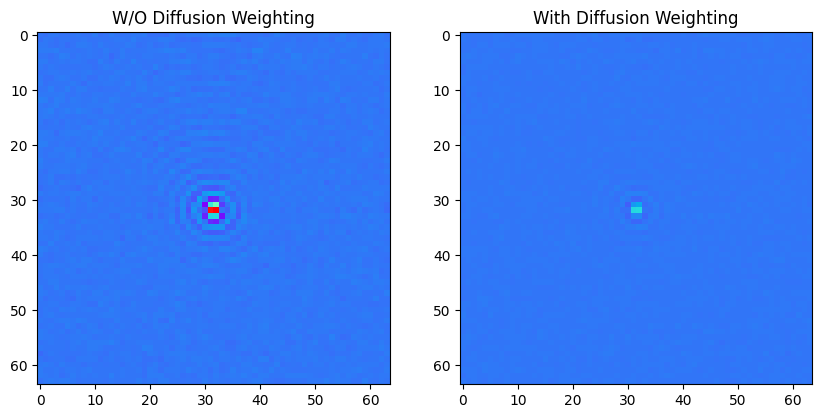

In [28]:
cmap = 'rainbow'
vmin = np.min(y_base.real)
vmax = np.max(y_base.real)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=100)
axes[0].imshow(y_base.real, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title('W/O Diffusion Weighting')
axes[1].imshow(y_diff.real, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('With Diffusion Weighting')
plt.show()

In [29]:
# LOAD_DIR = '/home/data/DWI-2D'
# LOAD_NAME = 'weed_stem_xdiff_80'
# y_base = np.load(f'{LOAD_DIR}/{LOAD_NAME}_base.npy')
# y_diff = np.load(f'{LOAD_DIR}/{LOAD_NAME}_diff.npy')
# seq.loadpar(f'{LOAD_DIR}/{LOAD_NAME}_diff.yaml')

### Images & ADC Map

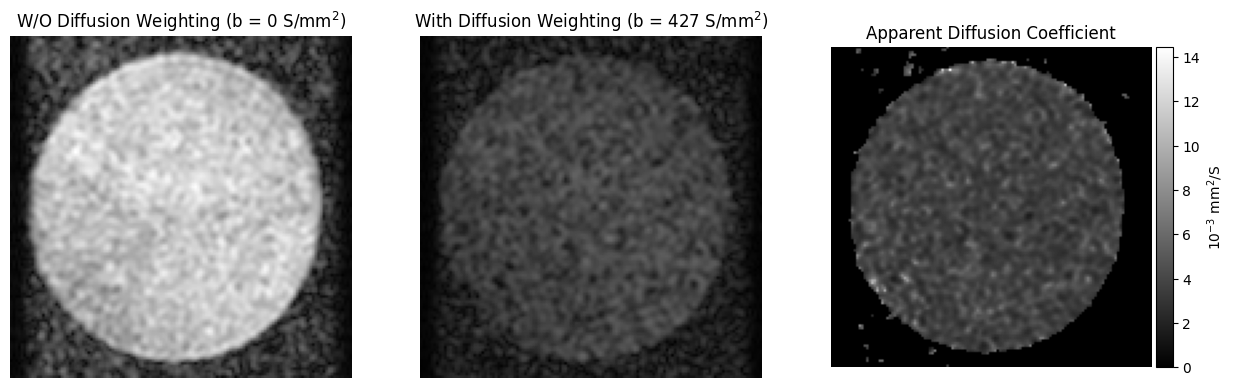

In [30]:
# reconstruct images from kspace data
im_base = np.abs(fft_reconstruction(y_base, upscale_factor=2, gaussian_blur=1))
im_diff = np.abs(fft_reconstruction(y_diff, upscale_factor=2, gaussian_blur=1))

plot_ADC(im_base, im_diff, b_base, b_diff, mask_ratio=0.25)